## Part 1:

Gather the dataset of hubNashville requests from https://data.nashville.gov/Public-Services/hubNashville-311-Service-Requests/7qhx-rexh. For this project, you should look at requests with Request Type of "COVID-19" and Subrequest Type of "COVID-19 Violations". Explore this dataset, looking at when and where these violations occurred.



In [1]:
import pandas as pd
import numpy as np
import requests
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [18]:
#getting data from API, case_requests = COVID-19 and setting limit to 25k

url = 'https://data.nashville.gov/resource/7qhx-rexh.json?case_request=COVID-19&$limit=25000'

response = requests.get(url)

In [19]:
#reading the json text to dataframe

hubNashville = pd.read_json(response.text)

In [36]:
#subsetting for case_requests and case_subrequest

hubNashville = hubNashville[hubNashville['case_subrequest'] == 'COVID-19 Violations']

In [40]:
hubNashville.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11632 entries, 1 to 15920
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   case_number                11632 non-null  int64         
 1   status                     11632 non-null  object        
 2   case_request               11632 non-null  object        
 3   case_subrequest            11632 non-null  object        
 4   additional_subrequest      11623 non-null  object        
 5   date_time_opened           11632 non-null  datetime64[ns]
 6   date_time_closed           11611 non-null  datetime64[ns]
 7   case_origin                11632 non-null  object        
 8   state_issue                11632 non-null  object        
 9   closed_when_created        11632 non-null  object        
 10  incident_address           11356 non-null  object        
 11  incident_city              10653 non-null  object        
 12  inci

In [31]:
#converting open and close to datetime

hubNashville['date_time_opened'] = [pd.to_datetime(d) for d in hubNashville['date_time_opened']]
hubNashville['date_time_closed'] = [pd.to_datetime(d) for d in hubNashville['date_time_closed']]

In [39]:
hubNashville.loc[hubNashville['incident_city'] == 'Nashville']

,case_number,status,case_request,case_subrequest,additional_subrequest,date_time_opened,date_time_closed,case_origin,state_issue,closed_when_created,incident_address,incident_city,incident_council_district,incident_zip_code,latitude,longitude,mapped_location,contact_type,parent_case
7039,361889,Closed,COVID-19,COVID-19 Violations,COVID-19 Violations,2020-05-07 18:57:32,2020-05-08 17:08:50,Phone,False,False,1297 Antioch Pike,Nashville,NaN,37211.0,NaN,NaN,NaN,NaN,NaN


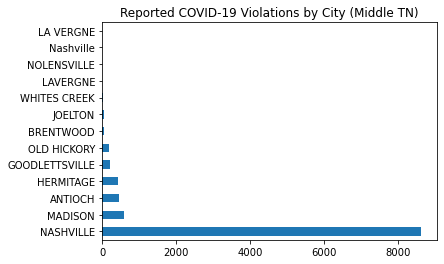

In [30]:
hubNashville['incident_city'].value_counts().plot(kind='barh', 
                                                  title='Reported COVID-19 Violations by City (Middle TN)');

Nashville leads the number of violations with 43